# 03. Aggregating Experiments

**Note**: the appearance of this notebook will depend on the environment and screen size you're using. If the tables are being clipped or the figures look off, consider trying Google Colab or Github via the buttons below. This notebook was created in VSCode, and will likely look best locally.

<a target="_blank" href="https://colab.research.google.com/github/ioverho/bayes_conf_mat/blob/main/documentation/Getting%20Started/03_aggregating_experiments.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/Run_in_Colab-_?style=for-the-badge&logo=googlecolab&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fbayes_conf_mat%2Fblob%2Fmain%2Fdocumentation%2FGetting%2520Started%2F03_aggregating_experiments.ipynb">
</a>
<a target="_blank" href="https://github.com/ioverho/bayes_conf_mat/blob/main/documentation/Getting%20Started/03_aggregating_experiments.ipynb">
  <img alt="Static Badge" src="https://img.shields.io/badge/View_in_Github-_?style=for-the-badge&logo=github&labelColor=gray&color=1082c3&link=https%3A%2F%2Fgithub.com%2Fioverho%2Fbayes_conf_mat%2Fblob%2Fmain%2Fdocumentation%2FGetting%2520Started%2F03_aggregating_experiments.ipynb">
</a>

## Setup

In this example, we're considering another common scenario. Unlike [the previous notebook](./02_comparing_experiments.ipynb), we ran several experiments using the *same* model, on different subsets of the same dataset (for example, through k-fold cross-validation). This gave us 5 independent folds, all of which together is going to say something about the average behaviour of the model on similar datasets.

In [1]:
fold_0 = [
    [32, 11],
    [0, 71],
]

fold_1 = [
    [33, 10],
    [1, 70],
]

fold_2 = [
    [25, 17],
    [0, 72],
]

fold_3 = [
    [42, 0],
    [24, 48],
]

fold_4 = [
    [34, 8],
    [3, 68],
]


For now we'll add the confusion matrices as before, and use the [adjusted Balanced Accuracy score](https://scikit-learn.org/dev/modules/model_evaluation.html#balanced-accuracy-score) as our metric.

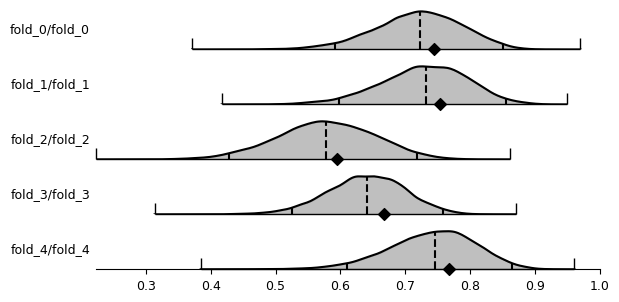

In [2]:
from bayes_conf_mat import Study

study = Study(
    seed=0,
    num_samples=10000,
    ci_probability=0.95,
)

for i, conf_mat in enumerate([fold_0, fold_1, fold_2, fold_3, fold_4]):
    study.add_experiment(
        f"fold_{i}",
        conf_mat,
        confusion_prior=1,
        prevalence_prior=1,
    )

study.add_metric(metric="ba+adjusted=True")

fig = study.plot_metric_summaries(
    metric="ba+adjusted=True",
    normalize=True,
)


In [3]:
study.report_metric_summaries(metric="ba+adjusted=True")


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
fold_0,fold_0,0.7442,0.7226,0.7282,"[0.5915, 0.8499]",0.2584,-0.3079,0.0694
fold_1,fold_1,0.7534,0.7322,0.7241,"[0.5976, 0.8548]",0.2572,-0.3055,-0.0176
fold_2,fold_2,0.5952,0.5781,0.5694,"[0.4285, 0.7173]",0.2888,-0.1290,-0.1465
fold_3,fold_3,0.6667,0.6412,0.6516,"[0.5259, 0.7573]",0.2313,-0.2383,0.0886
fold_4,fold_4,0.7673,0.7455,0.7678,"[0.6097, 0.8640]",0.2543,-0.4009,0.1590


In a standard analysis, we would simply report the average of the 5 observed values and call it a day. However, given that the dataset is small, and yields wide distributions of metric values, this would only provide part of the picture. Ideally, we'd be able to report an average *distribution* of metric values. Intuitively, this distribution would be much more precise (i.e. narrow), and centered close to the various averages.

## Experiment Aggregation

This is possible using a variety of methods. We use [conflation](https://arxiv.org/abs/0808.1808), an operation that generates an aggregate distribution that minimizes the loss of information. This requires making a parametric assumption though. If we (roughly) know the distribution type of the metric distributions, we can compute the conflated distribution in closed form for many different distribution families. Usually, as long as the distributions aren't clumped near the metric boundaries, the normal/Gaussian distribution is a decent first guess.

To get started we'll register the various confusion matrices again, but now to the same group (note the "group/experiment" structure).


In [4]:
del study

study = Study(
    seed=0,
    num_samples=10000,
    ci_probability=0.95,
)

for i, conf_mat in enumerate([fold_0, fold_1, fold_2, fold_3, fold_4]):
    study.add_experiment(
        f"foo/fold_{i}",
        conf_mat,
        confusion_prior=1,
        prevalence_prior=1,
    )


And we'll also add the same metric again, but now with the 'aggregation' key specified.

In [5]:
study.add_metric(metric="ba+adjusted=True", aggregation="gaussian")


We can now request the aggregated distribution as well.

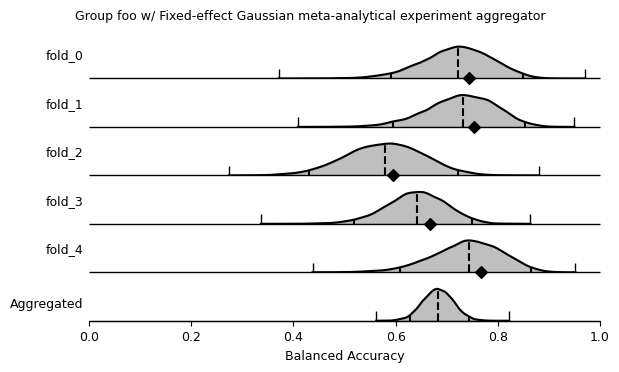

In [6]:
fig = study.plot_experiment_aggregation(
    metric="ba+adjusted=True",
    experiment_group="foo",
    normalize=True,
)


In [7]:
study.report_aggregated_metric_summaries(metric="ba+adjusted=True")


Group,Median,Mode,95.0% HDI,MU,Skew,Kurt,Var. Within,Var. Between,I2
foo,0.6831,0.6774,"[0.6289, 0.7438]",0.1149,-0.0121,-0.0161,0.0045,0.0000,0.00%


Looking at the figure and the table, the aggregated distribution is indeed much narrower (the MU is roughly half the size of the individual experiment distributions) and both the observed values and the medians of their distributions are symmetrically spread around the aggregated median value of $0.7071$.

The summary table now reports three additional metrics:
1. **Var. Within**: measure the variance of the distributions within each experiment
2. **Var. Between**: measure the variance between the different experiment distributions
3. **I2**: is the ratio of the variance between distrubtions to the total variance
These metrics have to do with the observed heterogeneity between the different distributions. Currently there is none ($I^2=4.28\%$), but we'll experiment with a case where this is the case later.

## Parametric Assumptions

The parametric assumption we make can impact the shape and summary statistics of the final aggregated distribution. For example, the independent experiment distributions are all negatively skewed. We assumed the aggregated distribution to be a Gaussian, which has no skew or excess kurtosis. If instead, we had chosen a Beta distribution would we have gotten a substantially different result?


In [8]:
study.add_metric(metric="ba+adjusted=True", aggregation="beta")

study.report_aggregated_metric_summaries(metric="ba+adjusted=True")


Group,Median,Mode,95.0% HDI,MU,Skew,Kurt,Var. Within,Var. Between,I2
foo,0.6845,0.6821,"[0.6257, 0.7452]",0.1196,-0.0794,0.0822,0.0044,0.0001,3.04%


Not really... although the new aggregate distribution is slightly negatively skewed as well now. Currently we've implemented the following aggregation methods:

In [9]:
from collections import defaultdict

from bayes_conf_mat.experiment_aggregation import AGGREGATION_REGISTRY

method_to_alias = defaultdict(list)
for alias, method in AGGREGATION_REGISTRY.items():
    method_to_alias[method].append(alias)

for method, aliases in method_to_alias.items():
    print(f"{method.__name__}: {aliases}")


SingletonAggregator: ['singleton', 'identity']
BetaAggregator: ['beta', 'beta_conflation']
FEGaussianAggregator: ['fe', 'fixed_effect', 'fe_gaussian', 'gaussian', 'normal', 'fe_normal']
REGaussianAggregator: ['re', 'random_effect', 're_gaussian', 're_normal']
HistogramAggregator: ['hist', 'histogram']
GammaAggregator: ['gamma', 'gamma_conflation']
FELogGaussianAggregator: ['fe_log_gaussian', 'log_gaussian', 'log_normal']


Which is best will depend on the parametric assumption one is willing to make, and the metric. For example, the 'histogram' method does not make a parametric assumption at all, and instead computes the conflated distribution using probability density estimates using the distribution's histogram. It fails whenever there are regions of non-overlap between different experiments. Since that isn't the case here, we safely use it:

In [10]:
study.add_metric(metric="ba+adjusted=True", aggregation="histogram")

study.report_aggregated_metric_summaries(metric="ba+adjusted=True")


Group,Median,Mode,95.0% HDI,MU,Skew,Kurt,Var. Within,Var. Between,I2
foo,0.6854,0.6835,"[0.6251, 0.7519]",0.1267,-0.1119,0.1342,0.0044,0.0001,2.53%


Most metrics are bounded in the regions [0, 1] or [-1, 1]. In those cases, the Beta distribution is especially strong. Some metrics, though, are not bounded or only bounded on one side. For example, the diagnostic odds ratio (a ratio of ratios) is bounded by [0, $\infty$). In that case, a Gamma distribution might be a better fit:

In [11]:
study.add_metric(metric="dor", aggregation="gamma")

study.report_aggregated_metric_summaries(metric="dor", class_label=0)


Group,Median,Mode,95.0% HDI,MU,Skew,Kurt,Var. Within,Var. Between,I2
foo,5.3086,0.8144,"[6.3628e-09, 61.0066]",61.0066,2.9846,12.0723,2702959667.0963,0.0000,0.00%


When looking at the distribution plot, however, it is clear that this is a particularly poorly behaved metric distribution, likely due to the fact that the confusion matrices have zero counts in the off-diagonal elements. These give non-finite results:

In [12]:
study.report_metric_summaries(metric="dor", class_label=0)


/home/ioverho/bayes_conf_mat/src/bayes_conf_mat/metrics/_metrics.py:965: RuntimeWarning: divide by zero encountered in divide
  return tpr / fpr
/home/ioverho/bayes_conf_mat/src/bayes_conf_mat/metrics/_metrics.py:1152: RuntimeWarning: divide by zero encountered in divide
  return plr / nlr


Group,Experiment,Observed,Median,Mode,95.0% HDI,MU,Skew,Kurt
foo,fold_0,inf,300.7750,102.9660,"[19.3161, 4371.1336]",4351.8175,50.7696,3056.8731
foo,fold_1,231.0000,135.7813,67.4365,"[15.8327, 696.0532]",680.2205,56.5959,4457.6553
foo,fold_2,inf,151.3990,48.0585,"[7.8530, 2122.3753]",2114.5222,78.6223,6795.9909
foo,fold_3,inf,124.2630,42.2460,"[7.5551, 1742.3460]",1734.7908,56.6083,3710.3558
foo,fold_4,96.3333,75.6193,45.3065,"[13.3525, 256.1462]",242.7937,3.9357,30.4562


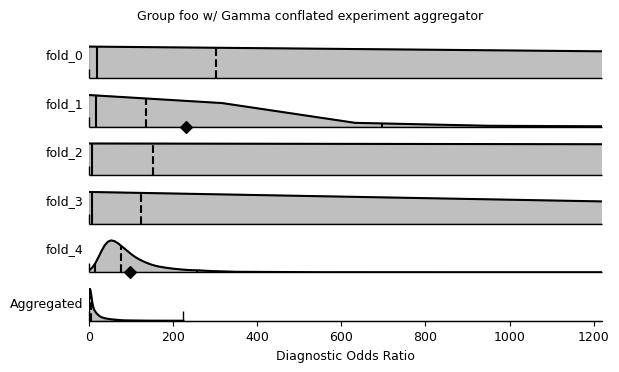

In [13]:
fig = study.plot_experiment_aggregation(
    metric="dor",
    class_label=0,
    experiment_group="foo",
    normalize=True,
)


In that case, using the same metric, but log-transformed, we get a much easier distribution to aggregate:

In [14]:
study.add_metric(metric="log_dor", aggregation="normal")

study.report_aggregated_metric_summaries(metric="log_dor", class_label=0)


Group,Median,Mode,95.0% HDI,MU,Skew,Kurt,Var. Within,Var. Between,I2
foo,4.8418,4.8560,"[3.9684, 5.6893]",1.7209,-0.0297,0.0085,1.2940,0.0000,0.00%


/home/ioverho/bayes_conf_mat/src/bayes_conf_mat/metrics/_metrics.py:965: RuntimeWarning: divide by zero encountered in divide
  return tpr / fpr
/home/ioverho/bayes_conf_mat/src/bayes_conf_mat/metrics/_metrics.py:1152: RuntimeWarning: divide by zero encountered in divide
  return plr / nlr
/home/ioverho/bayes_conf_mat/src/bayes_conf_mat/metrics/_metrics.py:1189: RuntimeWarning: divide by zero encountered in log
  log_dor = np.log(plr) - np.log(nlr)


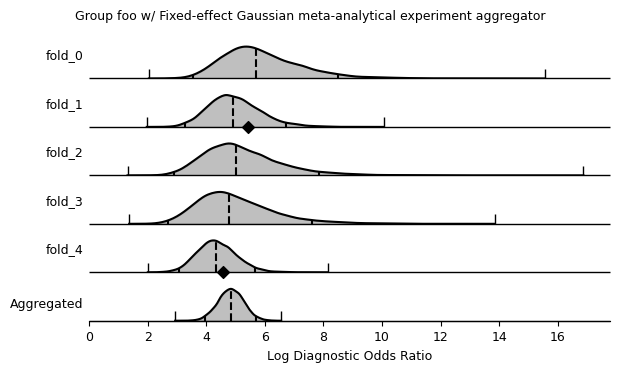

In [15]:
study.add_metric(metric="log_dor", aggregation="normal")

fig = study.plot_experiment_aggregation(
    metric="log_dor",
    class_label=0,
    experiment_group="foo",
    normalize=True,
)


## Forest Plots

While the `experiment_aggregation` plots are useful for visually establishing the shape of the metric distributions, and assessing to which degree the parametric assumptions made work, it is not the most efficient method for providing information about the experiments and their effect on the aggregated distribution.

For comparing multiple experiment groups at a quick glance, a forest plot strikes a good balance between the `report_aggregated_metric_summaries` and `plot_experiment_aggregation` methods. It is commonly used in the quantitative meta-analysis literature.

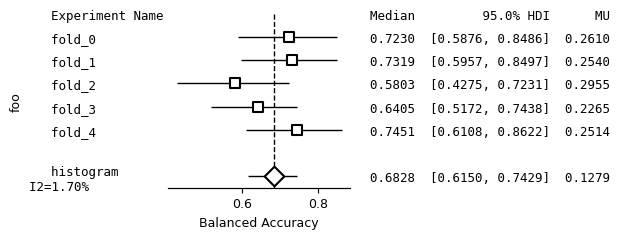

In [16]:
fig = study.plot_forest_plot(metric="ba+adjusted=True")


The medians of the individual experiments are depicted using squares, and their HDI uing a horizontal line. The aggregated distribution is shown at the bottom using a large diamond for its median. The vertical line allows for easy comparison of the individual experiments to the aggregated median. As usual, there are lots of customization options available.

## Dealing with Heterogeneity

Inter-exeperiment heterogeneity means that the individual experiments' medians lie far apart. So far we've only come across cases of little to no heterogeneity. There are instances, however, where one might expect substantially different metric distributions belonging to the same group. For example, if we're estimating the same model's performance on different datasets.

We can model this by adding an outlier distribution. Experiment group 'bar' is identical to 'foo' for the first 5 experiments, but includes a final outlier as well. This outlier experiment is very precise, relative to the rest.


In [17]:
study.add_metric(metric="ba+adjusted=True", aggregation="normal")

for i, conf_mat in enumerate([fold_0, fold_1, fold_2, fold_3, fold_4]):
    study.add_experiment(
        f"bar/fold_{i}",
        conf_mat,
        confusion_prior=1,
        prevalence_prior=1,
    )

outlier = [
    [164, 4],
    [8, 288],
]

study.add_experiment(
    experiment_name="bar/outlier",
    confusion_matrix=outlier,
    prevalence_prior=1.0,
    confusion_prior=1.0,
)


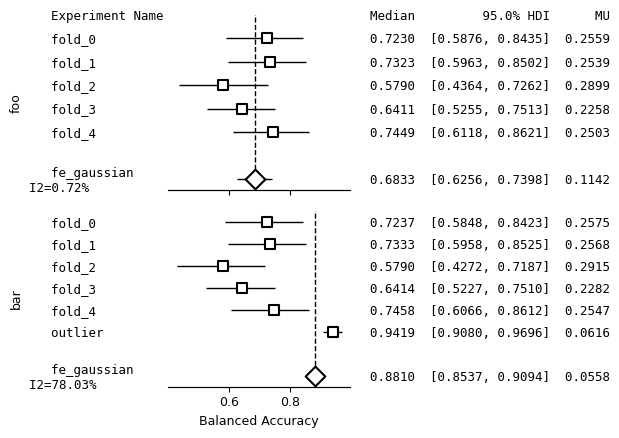

In [18]:
fig = study.plot_forest_plot(metric="ba+adjusted=True")


All of a sudden, the aggregated distribution lies in no-man's land. It's median does not lie within the HDI of any of the individual experiments. What's worse, the aggregated distribution is extremely narrow: we're extremely confident that the average metric lies in a region of values not seen in any of the other experiments!

Note that the I2 score is also provided. In the case without the outlier, this score was still very low $\approx3\%$. With the outlier, however, it is now $\approx 78\%$. This means that the inter-experiment variance represents roughly 3/4 of the total variance in the different experiments, which corresponds to a high degree of heterogeneity.

What can we do about it? The `REGaussianAggregator` aggregator employs a random-effects meta-analysis approach. It assumes the different experiments will have some degree of inter-experiment variance, and tries to explicitly correct for it.


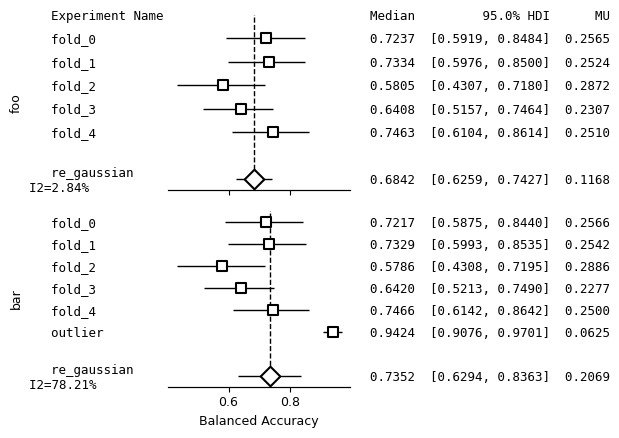

In [19]:
study.add_metric(metric="ba+adjusted=True", aggregation="re_normal")

fig = study.plot_forest_plot(metric="ba+adjusted=True")


When using it, we can immediately see the reduced effect of the outlier. While the aggregate distribution has still shifted somewhat, it now lies comfortably within the HDI of most experiments. Furthermore, the aggregate distribution is considerably wider, less precise.

So, in cases where you might expect heterogeneity to be present, consider using the `re_gaussian` approach, as it's considerably more robust. Unfortunately, we have (not yet) implemented robust variants for the other aggregation methods.

## Next Steps